In [1]:
import torch
import numpy as np
from tqdm.notebook import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Scientific computing
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

# ML & Analysis
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
from skdim.id import TwoNN, MLE

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import os

# Configuration
COLORS = {
    'layer0': '#2d77a6',  # Blue
    'layer1': '#bf7b04',  # Orange
    'layer2': '#6ea66d',  # Green
    'layer3': '#808080',  # Gray
    'accent': '#d62728',  # Red
    'neutral': '#7f7f7f'
}

# Academic plotting style
plt.style.use('seaborn-v0_8-paper')
sns.set_context("paper", font_scale=1.2)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'mathtext.fontset': 'stix',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 13,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.axisbelow': True
})

In [2]:
# ============================================================================
# LOAD PREPROCESSED DATA
# ============================================================================

print("="*80)
print("LOADING PREPROCESSED HEAD REPRESENTATIONS")
print("="*80)

DATASET = "ESC50"

loaded = torch.load('heads_representations/' + DATASET.lower() + "_head_outputs_final.pt", map_location="cpu", weights_only=False)
head_outputs_final = loaded["head_outputs_final"]
sample_labels = loaded["labels"]
print(f"✓ Loaded {len(head_outputs_final)} heads, {len(sample_labels)} samples")

# Verify data integrity
n_samples = len(sample_labels)
n_classes = len(np.unique(sample_labels))
print(f"✓ Dataset: {n_samples} samples, {n_classes} classes")
print(f"✓ Class distribution: {np.bincount(sample_labels)}")

LOADING PREPROCESSED HEAD REPRESENTATIONS
✓ Loaded 184 heads, 2000 samples
✓ Dataset: 2000 samples, 50 classes
✓ Class distribution: [40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40]


In [3]:
# ============================================================================
# 1. INTRINSIC DIMENSIONALITY ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("1. INTRINSIC DIMENSIONALITY ANALYSIS")
print("="*80)

def compute_intrinsic_dim_metrics(X):
    """
    Compute multiple intrinsic dimensionality estimators using a single PCA computation.
    Returns the same metrics as the original code.
    """
    metrics = {}

    # --- PCA: calcolata una sola volta ---
    pca = PCA(n_components=min(X.shape))
    pca.fit(X)
    eigenvalues = pca.explained_variance_            # λ_i
    evr = pca.explained_variance_ratio_             # λ_i / Σλ_i
    evr_cumsum = np.cumsum(evr)

    # --- PCA-based metrics ---
    metrics['pca_90'] = np.argmax(evr_cumsum >= 0.90) + 1
    metrics['pca_95'] = np.argmax(evr_cumsum >= 0.95) + 1
    metrics['pca_99'] = np.argmax(evr_cumsum >= 0.99) + 1
    metrics['evr_pc1'] = evr[0]
    metrics['evr_pc2'] = evr[1] if len(evr) > 1 else 0
    metrics['evr_pc3'] = evr[2] if len(evr) > 2 else 0

    # --- Participation Ratio (PR) ---
    metrics['pr'] = (eigenvalues.sum() ** 2) / (eigenvalues ** 2).sum()

    # --- TwoNN estimator (non-linear) ---
    try:
        twonn = TwoNN()
        metrics['twonn'] = twonn.fit_transform(X)
    except:
        metrics['twonn'] = np.nan

    # --- MLE estimator (non-linear) ---
    try:
        mle = MLE()
        metrics['mle'] = mle.fit_transform(X)
    except:
        metrics['mle'] = np.nan

    # --- Shannon entropy of eigenspectrum ---
    evr_norm = evr / evr.sum()
    metrics['shannon_entropy'] = -np.sum(evr_norm * np.log(evr_norm + 1e-10))

    # --- Effective rank ---
    metrics['eff_rank'] = np.exp(metrics['shannon_entropy'])

    return metrics, pca

# Compute for all heads
print("\n▸ Computing intrinsic dimensionality metrics...")
head_id_results = {}

for head_id, head_repr in tqdm(head_outputs_final.items(), desc="ID Analysis"):
    X = head_repr.numpy()
    
    metrics, pca = compute_intrinsic_dim_metrics(X)
    
    # Add metadata
    layer = int(head_id.split('_')[0][1])
    block = int(head_id.split('_')[1][1])
    head = int(head_id.split('_')[2][1])
    
    head_id_results[head_id] = {
        **metrics,
        'layer': layer,
        'block': block,
        'head': head,
        'pca_obj': pca,
        'head_dim': X.shape[1]
    }

# Convert to DataFrame
id_df = pd.DataFrame(head_id_results).T
id_df.index.name = 'head_id'
id_df = id_df.reset_index()

print(f"✓ Analysis complete: {len(id_df)} heads")

# Statistical summary
print("\n▸ Statistical Summary by Layer:")
summary = id_df.groupby('layer').agg({
    'pca_90': ['mean', 'std', 'min', 'max'],
    'pca_99': ['mean', 'std', 'min', 'max'],
    'twonn': ['mean', 'std', 'min', 'max'],
    'pr': ['mean', 'std'],
    'eff_rank': ['mean', 'std'],
    'evr_pc1': ['mean', 'std']
})
print(summary)

# Statistical tests (ANOVA across layers)
print("\n▸ Statistical Tests (One-way ANOVA):")
for metric in ['pca_90', 'pca_99', 'twonn', 'pr', 'eff_rank']:
    groups = [id_df[id_df['layer'] == l][metric].dropna() for l in range(4)]
    f_stat, p_val = stats.f_oneway(*groups)
    print(f"  {metric:12s}: F={f_stat:.3f}, p={p_val:.4f} {'***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'n.s.'}")


1. INTRINSIC DIMENSIONALITY ANALYSIS

▸ Computing intrinsic dimensionality metrics...


ID Analysis:   0%|          | 0/184 [00:00<?, ?it/s]

✓ Analysis complete: 184 heads

▸ Statistical Summary by Layer:
          pca_90                       pca_99                       twonn  \
            mean       std min max       mean       std min max      mean   
layer                                                                       
0            2.0  1.069045   1   4       4.75  2.764572   2  10  5.452287   
1           7.75  2.016598   3  10    16.0625  3.043436   9  20  7.389999   
2      14.510417  2.615721   7  18  21.802083  1.670927  14  23  8.877474   
3          16.25  1.708987   8  19   22.96875  0.853913  19  24  8.969264   

                                             pr             eff_rank  \
            std       min        max       mean       std       mean   
layer                                                                  
0      1.255294  3.610228   7.545759   1.661875  0.661950   2.166634   
1      0.588872   6.47075   8.117387   5.607049  1.797400   8.097831   
2      1.331794  5.681804  11.347538

In [4]:
# colonne che devono rimanere stringhe
string_cols = ['head_id', 'pca_obj']

# tutte le altre diventano numeriche
for col in id_df.columns:
    if col not in string_cols:
        id_df[col] = pd.to_numeric(id_df[col], errors='coerce')

In [5]:
id_df.to_csv('id_df.csv', index=False)

In [5]:
# ============================================================================
# BLOCK-WISE METRICS VISUALIZATION (INTEGRATED VERSION)
# ============================================================================
# Insert this after the intrinsic dimensionality analysis section

print("\n" + "="*80)
print("BLOCK-WISE AGGREGATED METRICS")
print("="*80)

# Verify that block information exists
if 'block' not in id_df.columns:
    print("⚠️  Block column not found. Extracting from head_id...")
    id_df['block'] = id_df['head_id'].apply(lambda x: int(x.split('_')[1][1]))
    id_df['head'] = id_df['head_id'].apply(lambda x: int(x.split('_')[2][1]))

# Define HTSAT structure (typical configuration - adjust if needed)
# Standard HTSAT has depths: [2, 2, 6, 2] for 4 layers
HTSAT_DEPTHS = [2, 2, 6, 2]  # Adjust this if your model differs

# Compute global block index
def get_global_block(row):
    """Convert (layer, block) to global block index."""
    layer = row['layer']
    block = row['block']
    blocks_before = sum(HTSAT_DEPTHS[:layer])
    return blocks_before + block

id_df['global_block'] = id_df.apply(get_global_block, axis=1)

# Verify structure
n_blocks = sum(HTSAT_DEPTHS)
print(f"\n📐 HTSAT Structure:")
print(f"   Depths per layer: {HTSAT_DEPTHS}")
print(f"   Total blocks: {n_blocks}")
print(f"   Block distribution: L0: 0-{HTSAT_DEPTHS[0]-1}, L1: {sum(HTSAT_DEPTHS[:1])}-{sum(HTSAT_DEPTHS[:2])-1}, "
      f"L2: {sum(HTSAT_DEPTHS[:2])}-{sum(HTSAT_DEPTHS[:3])-1}, L3: {sum(HTSAT_DEPTHS[:3])}-{sum(HTSAT_DEPTHS[:4])-1}")

# Debug: verify aggregation for first few blocks
print("\n🔍 Sample block composition:")
for b in range(n_blocks):
    block_data = id_df[id_df['global_block'] == b]
    print(f"   Block {b}: {len(block_data)} heads - {block_data['head_id'].tolist()}")

# Aggregate metrics per block (mean across all heads in the block)
metrics_to_aggregate = ['pca_99', 'twonn', 'evr_pc1', 'pr']

block_metrics = []
for b in range(n_blocks):
    block_data = id_df[id_df['global_block'] == b]
    
    if len(block_data) == 0:
        print(f"⚠️  Warning: Block {b} has no data!")
        continue
    
    # Compute metrics
    L = block_data['pca_99'].mean()  # Linear ID
    N = block_data['twonn'].mean()   # Nonlinear ID

    Ratio = L / N if N > 0 else np.nan  # Ratio L/N
    EVR1 = block_data['evr_pc1'].mean()  # First PC dominance
    
    block_metrics.append({
        'Block': b,
        'L': L,
        'N': N,
        'Ratio': Ratio,
        'EVR1': EVR1,
        'n_heads': len(block_data),
        'layer': block_data['layer'].iloc[0]
    })

metrics_df = pd.DataFrame(block_metrics)
print(f"\n📊 Metrics computed for {len(metrics_df)} blocks")
print(metrics_df[['Block', 'L', 'N', 'Ratio', 'EVR1', 'n_heads']])


BLOCK-WISE AGGREGATED METRICS

📐 HTSAT Structure:
   Depths per layer: [2, 2, 6, 2]
   Total blocks: 12
   Block distribution: L0: 0-1, L1: 2-3, L2: 4-9, L3: 10-11

🔍 Sample block composition:
   Block 0: 4 heads - ['L0_B0_H0', 'L0_B0_H1', 'L0_B0_H2', 'L0_B0_H3']
   Block 1: 4 heads - ['L0_B1_H0', 'L0_B1_H1', 'L0_B1_H2', 'L0_B1_H3']
   Block 2: 8 heads - ['L1_B0_H0', 'L1_B0_H1', 'L1_B0_H2', 'L1_B0_H3', 'L1_B0_H4', 'L1_B0_H5', 'L1_B0_H6', 'L1_B0_H7']
   Block 3: 8 heads - ['L1_B1_H0', 'L1_B1_H1', 'L1_B1_H2', 'L1_B1_H3', 'L1_B1_H4', 'L1_B1_H5', 'L1_B1_H6', 'L1_B1_H7']
   Block 4: 16 heads - ['L2_B0_H0', 'L2_B0_H1', 'L2_B0_H2', 'L2_B0_H3', 'L2_B0_H4', 'L2_B0_H5', 'L2_B0_H6', 'L2_B0_H7', 'L2_B0_H8', 'L2_B0_H9', 'L2_B0_H10', 'L2_B0_H11', 'L2_B0_H12', 'L2_B0_H13', 'L2_B0_H14', 'L2_B0_H15']
   Block 5: 16 heads - ['L2_B1_H0', 'L2_B1_H1', 'L2_B1_H2', 'L2_B1_H3', 'L2_B1_H4', 'L2_B1_H5', 'L2_B1_H6', 'L2_B1_H7', 'L2_B1_H8', 'L2_B1_H9', 'L2_B1_H10', 'L2_B1_H11', 'L2_B1_H12', 'L2_B1_H13', 'L2_B1_H

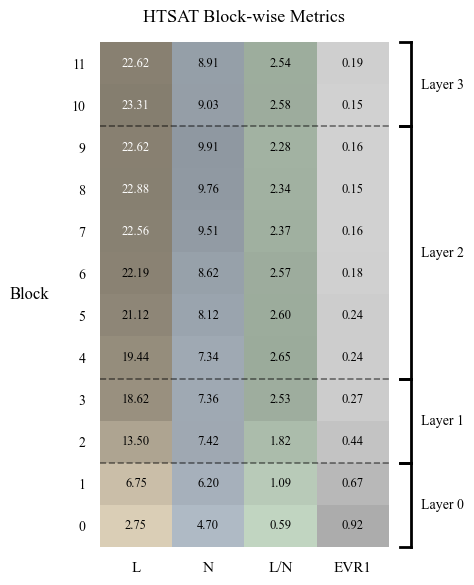

✅ Saved: htsat_block_metrics.png


In [6]:
# ============================================================================
# VISUALIZATION
# ============================================================================

# ============================================================================
# VISUALIZATION
# ============================================================================
from matplotlib.patches import Patch, FancyBboxPatch
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(5, n_blocks*0.5))

# Data
data = metrics_df[['L', 'N', 'Ratio', 'EVR1']].values
columns = ['L', 'N', 'L/N', 'EVR1']

# Base colors (più desaturati - tendenti al grigio)
palette = {
    'L': np.array([0.9, 0.85, 0.75]),    # beige desaturato
    'N': np.array([0.8, 0.85, 0.9]),     # azzurro desaturato
    'L/N': np.array([0.8, 0.88, 0.8]),   # verde desaturato
    'EVR1': np.array([0.85, 0.85, 0.85])  # grigio neutro
}

# Max values per colonna (per normalizzazione più accurata)
max_vals = {'L': 25, 'N': 15, 'L/N': 5, 'EVR1': 2}

# Draw heatmap: darker = higher values
for i in range(n_blocks):
    for j, col_name in enumerate(columns):
        val = data[i, j]
        if np.isnan(val):
            continue
        
        # Normalizzazione basata sui max conosciuti
        norm = val / max_vals[col_name]
        
        # Intensità media della scala: 0.45
        face_color = palette[col_name] * (1 - 0.45 * norm)
        
        rect = plt.Rectangle((j, i), 1, 1, facecolor=face_color, edgecolor=None)
        ax.add_patch(rect)
        
        # Overlay text
        text_color = 'white' if np.mean(face_color) < 0.5 else 'black'
        ax.text(j + 0.5, i + 0.5, f"{val:.2f}", ha='center', va='center',
                fontsize=9, fontweight='bold', color=text_color)

# Axes
ax.set_xlim(0, len(columns))
ax.set_ylim(0, n_blocks)
ax.set_xticks(np.arange(len(columns)) + 0.5)
ax.set_xticklabels(columns, fontsize=11, fontweight='bold')
ax.set_yticks(np.arange(n_blocks) + 0.5)
ax.set_yticklabels([str(b) for b in range(n_blocks)], fontsize=10)

# Layer boundaries con linee tratteggiate
cumsum = 0
layer_boundaries = [0]
for depth in HTSAT_DEPTHS[:-1]:
    cumsum += depth
    ax.axhline(y=cumsum, color='k', linewidth=1.2, linestyle='--', alpha=0.5)
    layer_boundaries.append(cumsum)
layer_boundaries.append(n_blocks)

# Parentesi quadre a destra per indicare i layer
bracket_x = len(columns) + 0.3  # posizione x delle parentesi
for layer_idx in range(len(HTSAT_DEPTHS)):
    y_start = layer_boundaries[layer_idx]
    y_end = layer_boundaries[layer_idx + 1]
    y_mid = (y_start + y_end) / 2
    
    # Disegno le parentesi quadre (verso destra)
    bracket_height = y_end - y_start
    bracket_width = 0.15
    
    # Linea verticale principale
    ax.plot([bracket_x, bracket_x], [y_start, y_end], 'k-', linewidth=2, clip_on=False)
    # Tacche orizzontali superiore e inferiore (verso DESTRA)
    ax.plot([bracket_x, bracket_x - bracket_width], [y_start, y_start], 'k-', linewidth=2, clip_on=False)
    ax.plot([bracket_x, bracket_x - bracket_width], [y_end, y_end], 'k-', linewidth=2, clip_on=False)
    
    # Etichetta del layer (numerazione corretta dal basso)
    layer_num = len(HTSAT_DEPTHS) - layer_idx
    ax.text(bracket_x + 0.15, y_mid, f'Layer {5 - layer_num - 1}', 
            ha='left', va='center', fontsize=10, fontweight='bold', clip_on=False)

# Minimal style
ax.set_ylabel('Block', fontsize=12, fontweight='bold', rotation=0, labelpad=30, va='center')
ax.set_title('HTSAT Block-wise Metrics', fontsize=13, fontweight='bold', pad=15)
ax.tick_params(left=False, top=False, bottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig('htsat_block_metrics.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Saved: htsat_block_metrics.png")

In [37]:
id_df

,head_id,pca_90,pca_95,pca_99,evr_pc1,evr_pc2,evr_pc3,pr,twonn,mle,shannon_entropy,eff_rank,layer,block,head,pca_obj,head_dim,global_block
0,L0_B0_H0,1,1,2,0.9606,0.034831,0.004201,1.08227,3.610228,3.319549,0.18158,1.199111,0,0,0,PCA(n_components=24),24,0
1,L0_B0_H1,1,2,3,0.929704,0.055633,0.007646,1.152707,5.234348,4.58754,0.308249,1.36104,0,0,1,PCA(n_components=24),24,0
2,L0_B0_H2,1,1,2,0.967602,0.02566,0.006162,1.067292,3.893891,3.471204,0.161792,1.175616,0,0,2,PCA(n_components=24),24,0
3,L0_B0_H3,2,2,4,0.806611,0.149658,0.032087,1.483488,6.064285,4.97668,0.63744,1.891632,0,0,3,PCA(n_components=24),24,0
4,L0_B1_H0,4,6,10,0.522528,0.252719,0.089872,2.865898,7.545759,6.885687,1.42754,4.16843,0,1,0,PCA(n_components=24),24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,L3_B1_H5,17,20,23,0.138646,0.11638,0.105301,13.917008,9.60209,11.353667,2.865278,17.553938,3,1,5,PCA(n_components=24),24,11
180,L3_B1_H6,15,18,22,0.182083,0.148302,0.106829,10.918551,9.011348,9.383629,2.702802,14.92149,3,1,6,PCA(n_components=24),24,11
181,L3_B1_H7,14,17,22,0.31556,0.108228,0.084879,7.332126,8.938249,10.386005,2.52963,12.548866,3,1,7,PCA(n_components=24),24,11
182,L3_B1_H8,13,16,21,0.22631,0.121548,0.116923,9.47344,7.882414,7.100432,2.586587,13.28436,3,1,8,PCA(n_components=24),24,11


In [38]:
cols_to_convert = id_df.columns.difference(['head_id', 'layer', 'block', 'head', 'pca_obj'])

id_df[cols_to_convert] = id_df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

In [46]:
id_df[['head_id', 'evr_pc1']].round(2).to_csv('id_df.csv', index=False)

In [29]:
id_df[['head_id', 'twonn', 'mle']]

,head_id,twonn,mle
0,L0_B0_H0,3.610228,3.319549
1,L0_B0_H1,5.234348,4.587540
2,L0_B0_H2,3.893891,3.471204
3,L0_B0_H3,6.064285,4.976680
4,L0_B1_H0,7.545759,6.885687
...,...,...,...
179,L3_B1_H5,9.602090,11.353667
180,L3_B1_H6,9.011348,9.383629
181,L3_B1_H7,8.938249,10.386005
182,L3_B1_H8,7.882414,7.100432


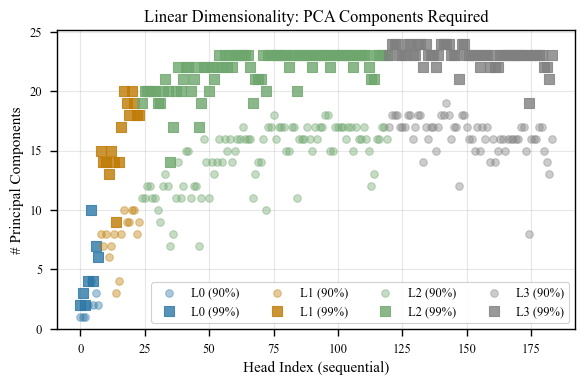

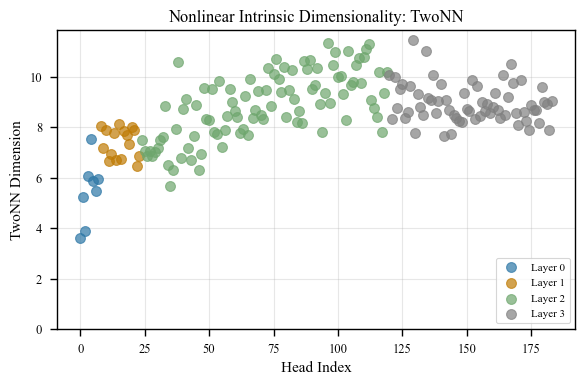

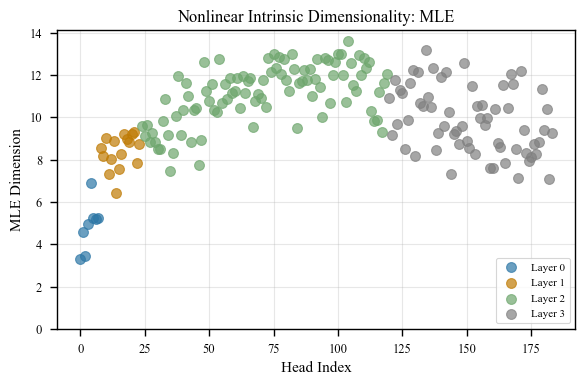

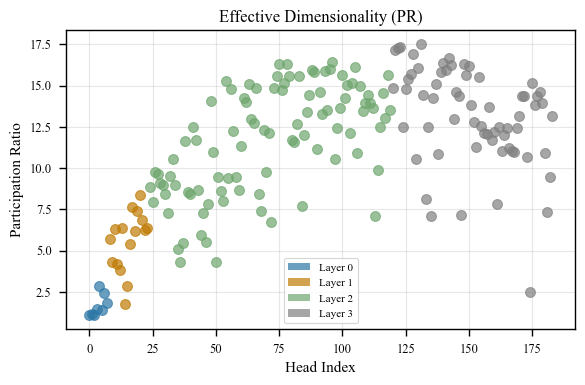

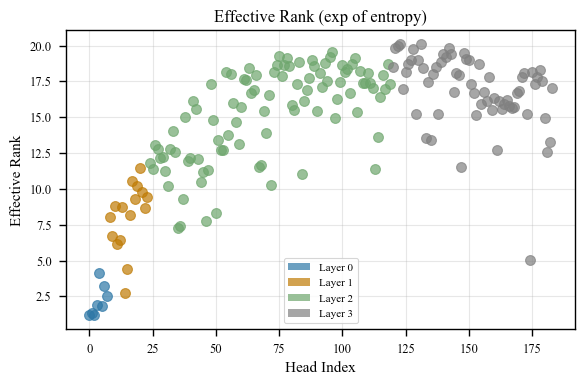

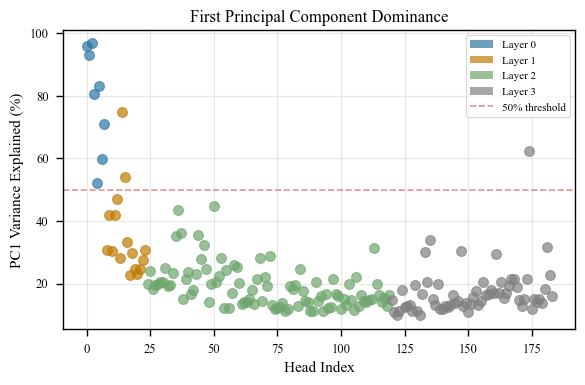

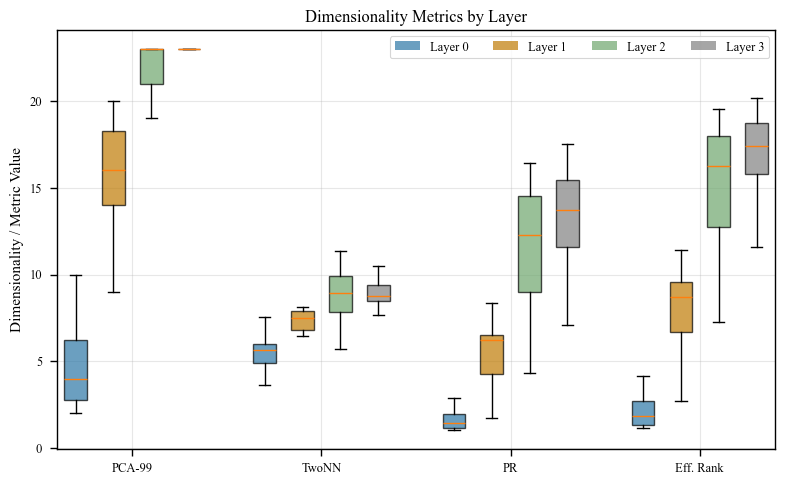

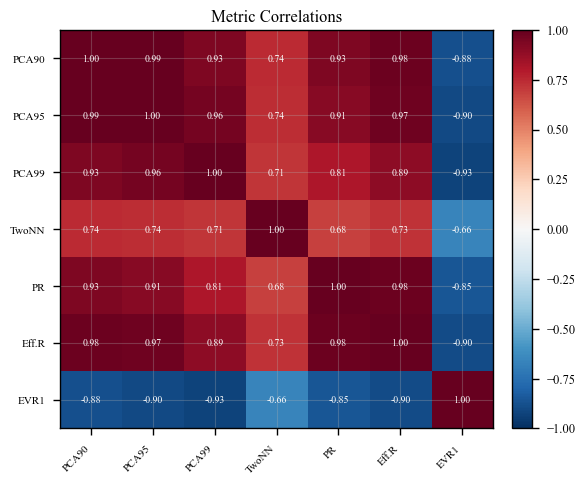

In [45]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

layer_colors = {0: COLORS['layer0'], 1: COLORS['layer1'], 2: COLORS['layer2'], 3: COLORS['layer3']}
x_pos = np.arange(len(id_df))

# -----------------------------
# Panel A: PCA components
# -----------------------------
fig, ax = plt.subplots(figsize=(6,4))
for layer in range(4):
    mask = id_df['layer'] == layer
    ax.scatter(x_pos[mask], id_df.loc[mask, 'pca_90'], 
               c=layer_colors[layer], alpha=0.4, s=30, marker='o', label=f'L{layer} (90%)')
    ax.scatter(x_pos[mask], id_df.loc[mask, 'pca_99'], 
               c=layer_colors[layer], alpha=0.8, s=50, marker='s', label=f"L{layer} (99%)")
ax.set_xlabel('Head Index (sequential)')
ax.set_ylabel('# Principal Components')
ax.set_title('Linear Dimensionality: PCA Components Required')
ax.legend(ncol=4, loc='lower right', framealpha=0.9)
ax.set_ylim(bottom=0)
plt.tight_layout()
plt.savefig('panel_A_pca_components.png', dpi=300)
plt.show()

# -----------------------------
# Panel B: TwoNN
# -----------------------------
fig, ax = plt.subplots(figsize=(6,4))
for layer in range(4):
    mask = id_df['layer'] == layer
    ax.scatter(
        x_pos[mask],
        id_df.loc[mask, 'twonn'],
        c=layer_colors[layer],
        alpha=0.7,
        s=50,
        label=f'Layer {layer}'
    )

ax.set_xlabel('Head Index')
ax.set_ylabel('TwoNN Dimension')
ax.set_title('Nonlinear Intrinsic Dimensionality: TwoNN')
ax.set_ylim(bottom=0)
ax.legend(fontsize=8, loc='lower right')
plt.tight_layout()
plt.savefig('panel_B_twonn.png', dpi=300)
plt.show()

# -----------------------------
# Panel C: MLE
# -----------------------------
fig, ax = plt.subplots(figsize=(6,4))
for layer in range(4):
    mask = id_df['layer'] == layer
    ax.scatter(
        x_pos[mask],
        id_df.loc[mask, 'mle'],
        c=layer_colors[layer],
        alpha=0.7,
        s=50,
        label=f'Layer {layer}'
    )

ax.set_xlabel('Head Index')
ax.set_ylabel('MLE Dimension')
ax.set_title('Nonlinear Intrinsic Dimensionality: MLE')
ax.set_ylim(bottom=0)
ax.legend(fontsize=8, loc='lower right')
plt.tight_layout()
plt.savefig('panel_C_mle.png', dpi=300)
plt.show()

# -----------------------------
# Panel D: Participation Ratio
# -----------------------------
fig, ax = plt.subplots(figsize=(6,4))
for layer in range(4):
    layer_data = id_df[id_df['layer'] == layer]
    ax.scatter(x_pos[id_df['layer'] == layer], layer_data['pr'],
               c=layer_colors[layer], alpha=0.7, s=50)
ax.set_xlabel('Head Index')
ax.set_ylabel('Participation Ratio')
ax.set_title('Effective Dimensionality (PR)')
legend_elements = [mpatches.Patch(facecolor=layer_colors[l], alpha=0.7, label=f'Layer {l}') 
                   for l in range(4)]
ax.legend(handles=legend_elements, fontsize=8, loc='lower center')
plt.tight_layout()
plt.savefig('panel_D_participation_ratio.png', dpi=300)
plt.show()

# -----------------------------
# Panel E: Effective Rank
# -----------------------------
fig, ax = plt.subplots(figsize=(6,4))
for layer in range(4):
    layer_data = id_df[id_df['layer'] == layer]
    ax.scatter(x_pos[id_df['layer'] == layer], layer_data['eff_rank'],
               c=layer_colors[layer], alpha=0.7, s=50)
ax.set_xlabel('Head Index')
ax.set_ylabel('Effective Rank')
ax.set_title('Effective Rank (exp of entropy)')
ax.legend(handles=legend_elements, fontsize=8, loc='lower center')
plt.tight_layout()
plt.savefig('panel_E_effective_rank.png', dpi=300)
plt.show()

# -----------------------------
# Panel F: PC1 Dominance
# -----------------------------
fig, ax = plt.subplots(figsize=(6,4))

for layer in range(4):
    layer_data = id_df[id_df['layer'] == layer]
    ax.scatter(
        x_pos[id_df['layer'] == layer], 
        layer_data['evr_pc1'] * 100,
        c=layer_colors[layer], alpha=0.7, s=50
    )

# aggiungi la linea threshold e salva il riferimento
threshold_line = ax.axhline(
    y=50, color=COLORS['accent'], linestyle='--', alpha=0.5, label='50% threshold'
)

# costruisci la legenda: unisci gli elementi già presenti + threshold
ax.legend(handles=legend_elements + [threshold_line], fontsize=8)

ax.set_xlabel('Head Index')
ax.set_ylabel('PC1 Variance Explained (%)')
ax.set_title('First Principal Component Dominance')

plt.tight_layout()
plt.savefig('panel_F_pc1_dominance.png', dpi=300)
plt.show()

# -----------------------------
# Panel G: Boxplot comparison
# -----------------------------
fig, ax = plt.subplots(figsize=(8,5))
metrics_to_plot = ['pca_99', 'twonn', 'pr', 'eff_rank']
positions = []
colors_list = []
data_to_plot = []

for i, metric in enumerate(metrics_to_plot):
    for layer in range(4):
        layer_data = id_df[id_df['layer'] == layer][metric].dropna()
        positions.append(i * 5 + layer)
        colors_list.append(layer_colors[layer])
        data_to_plot.append(layer_data)

bp = ax.boxplot(data_to_plot, positions=positions, widths=0.6,
                 patch_artist=True, showfliers=False)
for patch, color in zip(bp['boxes'], colors_list):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_xticks([i * 5 + 1.5 for i in range(len(metrics_to_plot))])
ax.set_xticklabels(['PCA-99', 'TwoNN', 'PR', 'Eff. Rank'])
ax.set_ylabel('Dimensionality / Metric Value')
ax.set_title('Dimensionality Metrics by Layer')
legend_elements = [mpatches.Patch(facecolor=layer_colors[l], alpha=0.7, label=f'Layer {l}') 
                   for l in range(4)]
ax.legend(handles=legend_elements, loc='upper right', ncol=4)
plt.tight_layout()
plt.savefig('panel_G_boxplot.png', dpi=300)
plt.show()

# -----------------------------
# Panel H: Correlation Heatmap
# -----------------------------
fig, ax = plt.subplots(figsize=(6,5))
corr_metrics = ['pca_90', 'pca_95', 'pca_99', 'twonn', 'pr', 'eff_rank', 'evr_pc1']
corr_matrix = id_df[corr_metrics].corr()

im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax.set_xticks(range(len(corr_metrics)))
ax.set_yticks(range(len(corr_metrics)))
ax.set_xticklabels(['PCA90', 'PCA95', 'PCA99', 'TwoNN', 'PR', 'Eff.R', 'EVR1'], 
                    rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(['PCA90', 'PCA95', 'PCA99', 'TwoNN', 'PR', 'Eff.R', 'EVR1'], fontsize=8)
ax.set_title('Metric Correlations')
# Add correlation values
for i in range(len(corr_metrics)):
    for j in range(len(corr_metrics)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="white" if abs(corr_matrix.iloc[i, j]) > 0.5 else "black",
                       fontsize=7)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig('panel_H_corr_heatmap.png', dpi=300)
plt.show()


HEAD SPECIALIZATION ANALYSIS - 3 ESSENTIAL PLOTS

⚙️  Configuration:
   Dataset: esc50
   HTSAT depths: [2, 2, 6, 2]

📂 Loading extracted head representations...
   ✅ Loaded 184 heads
   ✅ Loaded 2000 sample labels
   ✅ Unique classes: 50

🔬 Computing spectral metrics for all heads...


Computing metrics:   0%|          | 0/184 [00:00<?, ?it/s]

   ✅ Metrics computed for 184 heads

📊 Generating Plot 1: Spectral Fingerprinting...
   ✓ Saved: spectral_fingerprinting.pdf/png


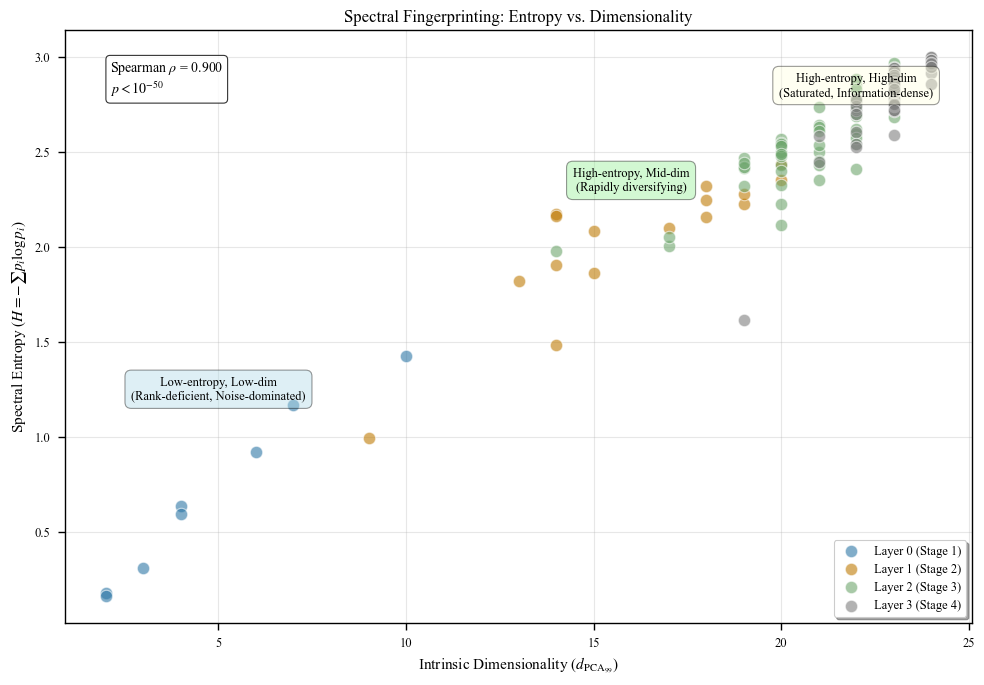


📊 Generating Plot 2: Head Similarity Matrix...
   Building eigenvalue spectra...


   Processing:   0%|          | 0/184 [00:00<?, ?it/s]

   Computing cosine similarity...
   Performing hierarchical clustering...
   ✓ Saved: head_similarity_matrix.pdf/png


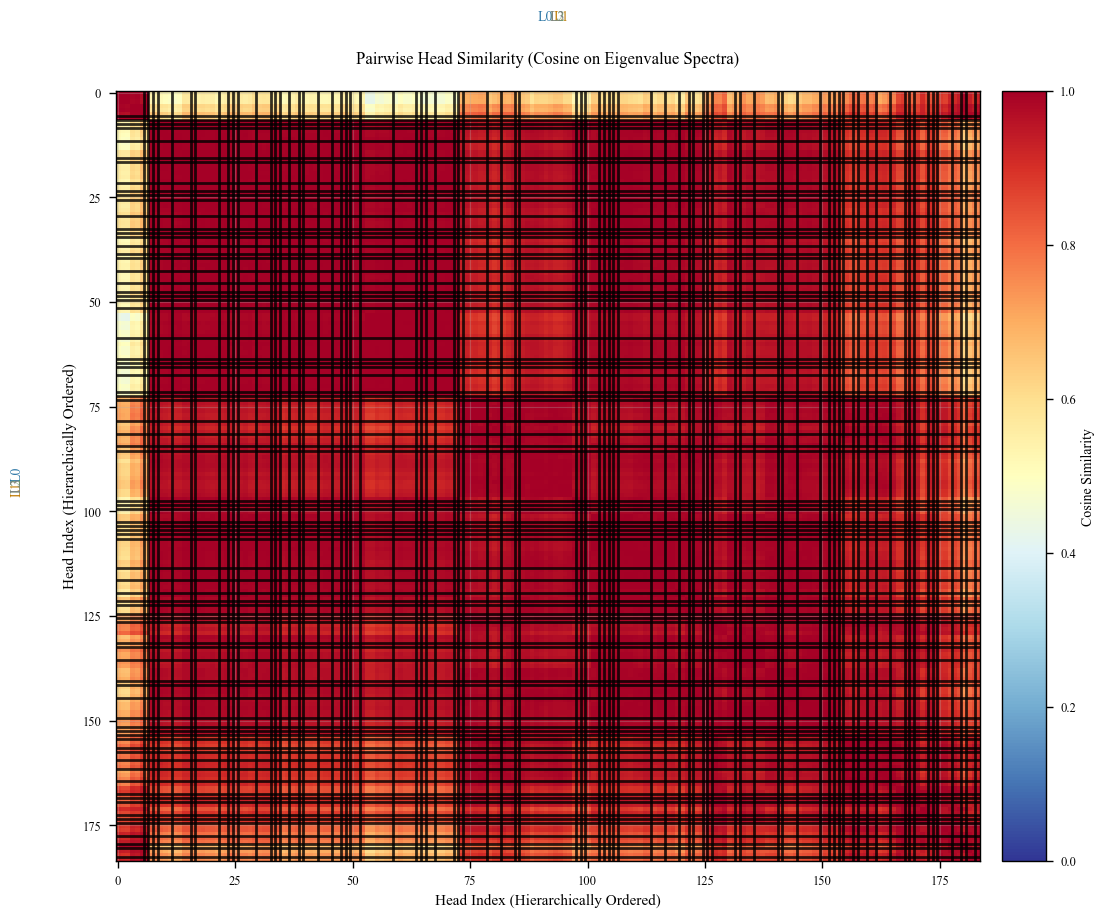


   📊 Similarity Statistics:
      Within-layer: 0.961
      Cross-layer: 0.909
      Ratio: 1.06x

📊 Generating Plot 3: Task Importance Analysis...
   Loading CLAP model...
   ✅ Model loaded
   Loading test dataset...
Loading audio files


2000it [00:00, 14298.02it/s]

   ✅ Using 100 test samples
   Computing baseline accuracy...


   Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

      Baseline: 97.00%
   Running block-level ablation...


   Ablating blocks:   0%|          | 0/12 [00:00<?, ?it/s]

   Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

      Block 0 (L0): Δ = 5.00%


   Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

      Block 1 (L0): Δ = 0.00%


   Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

      Block 2 (L1): Δ = -2.00%


   Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

      Block 3 (L1): Δ = 0.00%


   Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

      Block 4 (L2): Δ = 1.00%


   Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

      Block 5 (L2): Δ = 1.00%


   Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

      Block 6 (L2): Δ = 2.00%


   Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

      Block 7 (L2): Δ = 0.00%


   Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

      Block 8 (L2): Δ = 0.00%


   Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

      Block 9 (L2): Δ = 0.00%


   Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

      Block 10 (L3): Δ = 0.00%


   Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

      Block 11 (L3): Δ = 0.00%
   ✓ Saved: task_importance_analysis.pdf/png


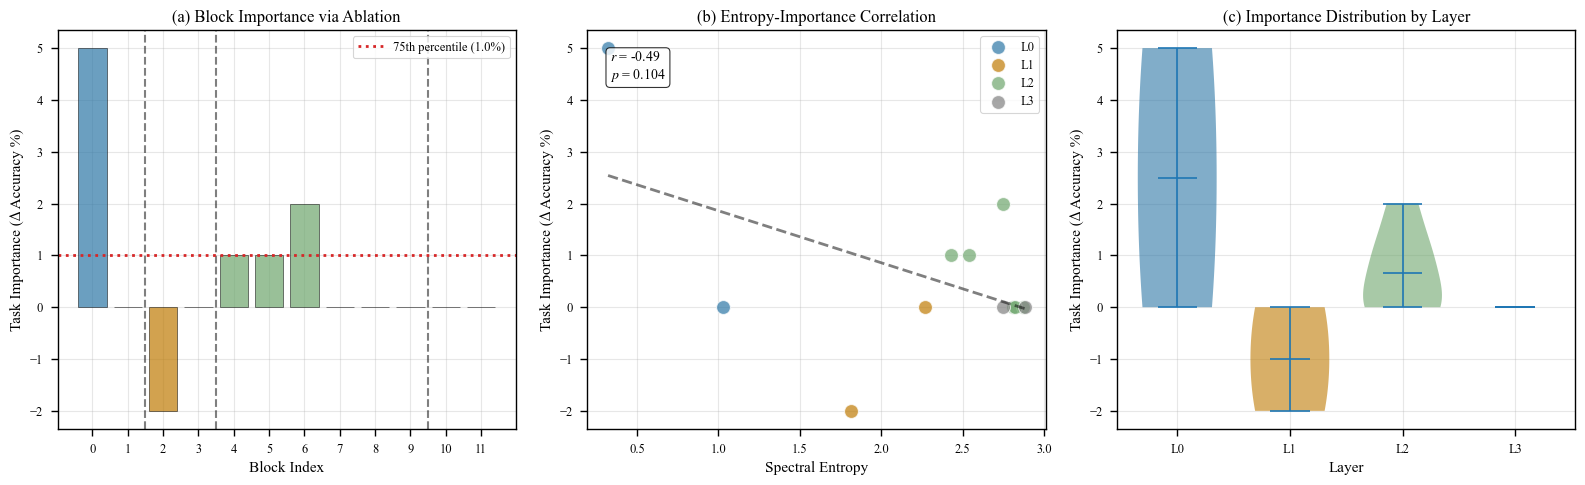


SUMMARY STATISTICS

📊 Spectral Fingerprinting:
   Spearman ρ (entropy vs dim): 0.900, p = 1.13e-67

📊 Similarity Structure:
   Within-layer: 0.961
   Cross-layer: 0.909
   Ratio: 1.06x

📊 Task Importance:
   Baseline accuracy: 97.00%
   Most critical block: 0
   Max importance: 5.00%
   Entropy-importance correlation: r = -0.49, p = 0.104

🎯 High-Impact Blocks (Δ > 1.0%):
   Block 0 (L0): Δ = 5.00%, Entropy = 0.32, PCA99 = 2.8
   Block 6 (L2): Δ = 2.00%, Entropy = 2.75, PCA99 = 22.2

✅ All 3 essential plots generated successfully!
   Files saved:
   - spectral_fingerprinting.pdf/png
   - head_similarity_matrix.pdf/png
   - task_importance_analysis.pdf/png


In [5]:
# ============================================================================
# HEAD SPECIALIZATION ANALYSIS - 3 ESSENTIAL PLOTS
# Complete rewrite with all fixes
# ============================================================================

import torch
import numpy as np
from tqdm.notebook import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Scientific computing
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr, linregress

# ML & Analysis
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity

# Visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd

# Configuration
COLORS = {
    'layer0': '#2d77a6',
    'layer1': '#bf7b04',
    'layer2': '#6ea66d',
    'layer3': '#808080',
    'accent': '#d62728',
    'neutral': '#7f7f7f'
}

plt.style.use('seaborn-v0_8-paper')
sns.set_context("paper", font_scale=1.2)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'mathtext.fontset': 'stix',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 13,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.axisbelow': True
})

layer_colors = {
    0: COLORS['layer0'],
    1: COLORS['layer1'],
    2: COLORS['layer2'],
    3: COLORS['layer3']
}

print("\n" + "="*80)
print("HEAD SPECIALIZATION ANALYSIS - 3 ESSENTIAL PLOTS")
print("="*80)

# ============================================================================
# CONFIGURATION
# ============================================================================
DATASET_NAME = 'esc50'  # Change to 'esc50' or 'tinysol' as needed
HTSAT_DEPTHS = [2, 2, 6, 2]

print(f"\n⚙️  Configuration:")
print(f"   Dataset: {DATASET_NAME}")
print(f"   HTSAT depths: {HTSAT_DEPTHS}")

# ============================================================================
# STEP 1: LOAD EXTRACTED HEAD REPRESENTATIONS
# ============================================================================
print("\n📂 Loading extracted head representations...")

data_path = f'heads_representations/{DATASET_NAME}_head_outputs_final.pt'
loaded_data = torch.load(data_path, weights_only=False)
head_outputs_final = loaded_data['head_outputs_final']
sample_labels = loaded_data['labels']

print(f"   ✅ Loaded {len(head_outputs_final)} heads")
print(f"   ✅ Loaded {len(sample_labels)} sample labels")
print(f"   ✅ Unique classes: {len(np.unique(sample_labels))}")

# ============================================================================
# STEP 2: COMPUTE SPECTRAL METRICS
# ============================================================================
print("\n🔬 Computing spectral metrics for all heads...")

head_metrics = []

for head_id in tqdm(sorted(head_outputs_final.keys()), desc="Computing metrics"):
    # Extract head data
    head_data = head_outputs_final[head_id].numpy()
    
    # Parse head info
    parts = head_id.split('_')
    layer = int(parts[0][1])
    block = int(parts[1][1])
    head = int(parts[2][1])
    
    # Compute PCA
    pca = PCA(n_components=head_data.shape[1])
    pca.fit(head_data)
    
    # Eigenvalues
    eigenvalues = pca.explained_variance_
    explained_var_ratio = pca.explained_variance_ratio_
    
    # Spectral entropy
    p = eigenvalues / eigenvalues.sum()
    p = p[p > 0]
    spectral_entropy = -np.sum(p * np.log(p))
    
    # Intrinsic dimensionality
    cumsum = np.cumsum(explained_var_ratio)
    pca_99 = np.argmax(cumsum >= 0.99) + 1
    pca_90 = np.argmax(cumsum >= 0.90) + 1
    
    # EVR PC1
    evr_pc1 = explained_var_ratio[0]
    
    # Participation Ratio
    pr = (eigenvalues.sum() ** 2) / (eigenvalues ** 2).sum()
    
    # Store
    head_metrics.append({
        'head_id': head_id,
        'layer': layer,
        'block': block,
        'head': head,
        'spectral_entropy': spectral_entropy,
        'pca_99': pca_99,
        'pca_90': pca_90,
        'evr_pc1': evr_pc1,
        'pr': pr,
        'eigenvalues': eigenvalues,
        'head_data': head_data
    })

metrics_df = pd.DataFrame(head_metrics)

# Compute global block index
def get_global_block(row):
    blocks_before = sum(HTSAT_DEPTHS[:row['layer']])
    return blocks_before + row['block']

metrics_df['global_block'] = metrics_df.apply(get_global_block, axis=1)

print(f"   ✅ Metrics computed for {len(metrics_df)} heads")

# ============================================================================
# PLOT 1: SPECTRAL FINGERPRINTING
# ============================================================================
print("\n📊 Generating Plot 1: Spectral Fingerprinting...")

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

for layer in sorted(metrics_df['layer'].unique()):
    layer_data = metrics_df[metrics_df['layer'] == layer]
    ax.scatter(
        layer_data['pca_99'],
        layer_data['spectral_entropy'],
        c=layer_colors[layer],
        label=f'Layer {layer} (Stage {layer+1})',
        s=80,
        alpha=0.6,
        edgecolors='white',
        linewidth=0.8
    )

# Regime annotations
ax.annotate('Low-entropy, Low-dim\n(Rank-deficient, Noise-dominated)',
            xy=(5, 1.2), fontsize=9, ha='center',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.4))

ax.annotate('High-entropy, Mid-dim\n(Rapidly diversifying)',
            xy=(16, 2.3), fontsize=9, ha='center',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.4))

ax.annotate('High-entropy, High-dim\n(Saturated, Information-dense)',
            xy=(22, 2.8), fontsize=9, ha='center',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.4))

# Correlation
rho, pval = spearmanr(metrics_df['pca_99'], metrics_df['spectral_entropy'])
ax.text(0.05, 0.95, f'Spearman $\\rho$ = {rho:.3f}\n$p < 10^{{-50}}$',
        transform=ax.transAxes, fontsize=10, va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_xlabel('Intrinsic Dimensionality ($d_{\\mathrm{PCA}_{99}}$)', fontsize=11)
ax.set_ylabel('Spectral Entropy ($H = -\\sum p_i \\log p_i$)', fontsize=11)
ax.set_title('Spectral Fingerprinting: Entropy vs. Dimensionality', 
             fontsize=12, fontweight='bold')
ax.legend(frameon=True, fancybox=True, shadow=True, loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('spectral_fingerprinting.pdf', dpi=300, bbox_inches='tight')
plt.savefig('spectral_fingerprinting.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: spectral_fingerprinting.pdf/png")
plt.show()

# ============================================================================
# PLOT 2: HEAD SIMILARITY MATRIX
# ============================================================================
print("\n📊 Generating Plot 2: Head Similarity Matrix...")

# Build eigenvalue spectra
print("   Building eigenvalue spectra...")
spectra = []
for idx in tqdm(metrics_df.index, desc="   Processing", leave=False):
    eigenvalues = metrics_df.loc[idx, 'eigenvalues']
    spectrum = eigenvalues[:24] / eigenvalues.sum()
    if len(spectrum) < 24:
        spectrum = np.pad(spectrum, (0, 24 - len(spectrum)), 'constant')
    spectra.append(spectrum)

spectra = np.array(spectra)

# Compute similarity
print("   Computing cosine similarity...")
similarity_matrix = cosine_similarity(spectra)

# Hierarchical clustering
print("   Performing hierarchical clustering...")
linkage_matrix = linkage(pdist(spectra), method='ward')
dendro = dendrogram(linkage_matrix, no_plot=True)
ordered_indices = dendro['leaves']

# Reorder
similarity_ordered = similarity_matrix[ordered_indices, :][:, ordered_indices]
ordered_layers = metrics_df.iloc[ordered_indices]['layer'].values

# Plot
fig = plt.figure(figsize=(12, 10))
gs = GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)

ax = fig.add_subplot(gs[0])
im = ax.imshow(similarity_ordered, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=1)

# Layer boundaries
layer_boundaries = []
current_layer = ordered_layers[0]
for i, layer in enumerate(ordered_layers):
    if layer != current_layer:
        layer_boundaries.append(i)
        current_layer = layer

for boundary in layer_boundaries:
    ax.axhline(y=boundary-0.5, color='black', linewidth=2, alpha=0.8)
    ax.axvline(x=boundary-0.5, color='black', linewidth=2, alpha=0.8)

ax.set_xlabel('Head Index (Hierarchically Ordered)', fontsize=11)
ax.set_ylabel('Head Index (Hierarchically Ordered)', fontsize=11)
ax.set_title('Pairwise Head Similarity (Cosine on Eigenvalue Spectra)', 
             fontsize=12, fontweight='bold', pad=20)

# Layer annotations
layer_positions = {}
for layer in range(4):
    layer_mask = ordered_layers == layer
    if np.any(layer_mask):
        start, end = np.where(layer_mask)[0][0], np.where(layer_mask)[0][-1]
        layer_positions[layer] = (start, end)

for layer, (start, end) in layer_positions.items():
    mid = (start + end) / 2
    ax.text(-20, mid, f'L{layer}', rotation=90, va='center', ha='right', 
            fontsize=10, fontweight='bold', color=layer_colors[layer])
    ax.text(mid, -20, f'L{layer}', rotation=0, va='top', ha='center',
            fontsize=10, fontweight='bold', color=layer_colors[layer])

# Colorbar
cax = fig.add_subplot(gs[1])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Cosine Similarity', fontsize=10)

plt.savefig('head_similarity_matrix.pdf', dpi=300, bbox_inches='tight')
plt.savefig('head_similarity_matrix.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: head_similarity_matrix.pdf/png")
plt.show()

# Compute statistics
within_layer_sims = []
for layer in range(4):
    layer_indices = metrics_df[metrics_df['layer'] == layer].index.tolist()
    if len(layer_indices) > 1:
        layer_sim_matrix = similarity_matrix[np.ix_(layer_indices, layer_indices)]
        upper_triangle = layer_sim_matrix[np.triu_indices_from(layer_sim_matrix, k=1)]
        within_layer_sims.extend(upper_triangle)

cross_layer_sims = []
for l1 in range(4):
    for l2 in range(l1+1, 4):
        l1_indices = metrics_df[metrics_df['layer'] == l1].index.tolist()
        l2_indices = metrics_df[metrics_df['layer'] == l2].index.tolist()
        cross_sim = similarity_matrix[np.ix_(l1_indices, l2_indices)].flatten()
        cross_layer_sims.extend(cross_sim)

within_mean = np.mean(within_layer_sims)
cross_mean = np.mean(cross_layer_sims)

print(f"\n   📊 Similarity Statistics:")
print(f"      Within-layer: {within_mean:.3f}")
print(f"      Cross-layer: {cross_mean:.3f}")
print(f"      Ratio: {within_mean/cross_mean:.2f}x")

# ============================================================================
# PLOT 3: TASK IMPORTANCE ANALYSIS (ABLATION STUDY)
# ============================================================================
print("\n📊 Generating Plot 3: Task Importance Analysis...")

# Load model and dataset
print("   Loading CLAP model...")
from CLAPWrapper import CLAPWrapper

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
wrapper = CLAPWrapper(version='2023', use_cuda=torch.cuda.is_available())
audio_encoder = wrapper.clap.audio_encoder.base.htsat
audio_encoder.eval()

print("   ✅ Model loaded")

# Load dataset
print("   Loading test dataset...")
if DATASET_NAME == 'vocalsound':
    from datasets.vocalsound import VocalSound
    test_dataset = VocalSound(root='../data', download=False)
elif DATASET_NAME == 'esc50':
    from datasets.esc50 import ESC50
    test_dataset = ESC50(root='../data', download=False)
elif DATASET_NAME == 'tinysol':
    from datasets.tinysol import TinySOL
    test_dataset = TinySOL(root='../data', download=False)

N_TEST_SAMPLES = min(100, len(test_dataset))
test_indices = np.random.choice(len(test_dataset), N_TEST_SAMPLES, replace=False)

print(f"   ✅ Using {N_TEST_SAMPLES} test samples")

# Define evaluation function
def compute_zero_shot_accuracy(wrapper_obj, dataset, indices, class_names):
    """Compute zero-shot accuracy using CLAPWrapper."""
    # Get text embeddings once
    text_prompts = [f"the sound of {cls}" for cls in class_names]
    text_embeddings = wrapper_obj.get_text_embeddings(text_prompts)
    
    correct = 0
    total = 0
    
    for idx in tqdm(indices, desc="   Evaluating", leave=False):
        audio_path, class_name, _ = dataset[idx]
        
        # Get audio embedding
        audio_embedding = wrapper_obj.get_audio_embeddings([audio_path], resample=True)
        
        # Compute similarity
        similarity = wrapper_obj.compute_similarity(audio_embedding, text_embeddings)
        
        # Prediction
        predicted_idx = similarity.argmax(dim=1).item()
        true_idx = class_names.index(class_name)
        
        if predicted_idx == true_idx:
            correct += 1
        total += 1
    
    return correct / total if total > 0 else 0.0

# Baseline accuracy
print("   Computing baseline accuracy...")
baseline_acc = compute_zero_shot_accuracy(wrapper, test_dataset, test_indices, test_dataset.classes)
print(f"      Baseline: {baseline_acc:.2%}")

# Ablation study
print("   Running block-level ablation...")

block_importance = []

for block_id in tqdm(range(12), desc="   Ablating blocks"):
    # Determine layer and block
    layer_idx = 0
    block_idx_in_layer = block_id
    for i, depth in enumerate(HTSAT_DEPTHS):
        if block_idx_in_layer < depth:
            layer_idx = i
            break
        block_idx_in_layer -= depth
    
    # Create ablation hook
    def ablation_hook(module, input, output):
        x, attn = output
        return (torch.zeros_like(x), attn)
    
    # Register hook
    target_block = audio_encoder.layers[layer_idx].blocks[block_idx_in_layer]
    hook = target_block.attn.register_forward_hook(ablation_hook)
    
    # Evaluate with ablation
    ablated_acc = compute_zero_shot_accuracy(wrapper, test_dataset, test_indices, test_dataset.classes)
    
    # Remove hook
    hook.remove()
    
    # Store results
    delta_acc = baseline_acc - ablated_acc
    block_importance.append({
        'block': block_id,
        'layer': layer_idx,
        'delta_acc': delta_acc * 100,
        'ablated_acc': ablated_acc * 100
    })
    
    print(f"      Block {block_id} (L{layer_idx}): Δ = {delta_acc*100:.2f}%")

importance_df = pd.DataFrame(block_importance)

# Merge with spectral metrics
block_metrics_agg = metrics_df.groupby('global_block').agg({
    'spectral_entropy': 'mean',
    'pca_99': 'mean',
    'evr_pc1': 'mean',
    'layer': 'first'
}).reset_index()

importance_df = importance_df.merge(
    block_metrics_agg, 
    left_on='block', 
    right_on='global_block',
    how='left'
)

# Create 3-panel plot
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel A: Block importance
ax = axes[0]
ax.bar(importance_df['block'], importance_df['delta_acc'], 
       color=[layer_colors[l] for l in importance_df['layer_x']], 
       alpha=0.7, edgecolor='black', linewidth=0.5)

for boundary in [1.5, 3.5, 9.5]:
    ax.axvline(x=boundary, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

threshold = importance_df['delta_acc'].quantile(0.75)
ax.axhline(y=threshold, color=COLORS['accent'], linestyle=':', linewidth=2, 
           label=f'75th percentile ({threshold:.1f}%)')

ax.set_xlabel('Block Index', fontsize=11)
ax.set_ylabel('Task Importance (Δ Accuracy %)', fontsize=11)
ax.set_title('(a) Block Importance via Ablation', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(range(12))
ax.legend(loc='upper right', fontsize=9)

# Panel B: Entropy correlation
ax = axes[1]
for layer in sorted(importance_df['layer_x'].unique()):
    layer_data = importance_df[importance_df['layer_x'] == layer]
    ax.scatter(layer_data['spectral_entropy'], layer_data['delta_acc'],
               c=layer_colors[layer], label=f'L{layer}', s=100, alpha=0.7,
               edgecolors='white', linewidth=0.8)

slope, intercept, r_value, p_value, std_err = linregress(
    importance_df['spectral_entropy'], importance_df['delta_acc']
)
x_trend = np.linspace(importance_df['spectral_entropy'].min(), 
                      importance_df['spectral_entropy'].max(), 100)
y_trend = slope * x_trend + intercept
ax.plot(x_trend, y_trend, 'k--', alpha=0.5, linewidth=2)

ax.text(0.05, 0.95, f'$r$ = {r_value:.2f}\n$p$ = {p_value:.3f}',
        transform=ax.transAxes, fontsize=10, va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_xlabel('Spectral Entropy', fontsize=11)
ax.set_ylabel('Task Importance (Δ Accuracy %)', fontsize=11)
ax.set_title('(b) Entropy-Importance Correlation', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Panel C: Distribution by layer
ax = axes[2]
layer_importance = importance_df.groupby('layer_x')['delta_acc'].apply(list).to_dict()
positions = list(range(len(layer_importance)))
data_to_plot = [layer_importance[i] for i in sorted(layer_importance.keys())]

parts = ax.violinplot(data_to_plot, positions=positions, widths=0.7, 
                      showmeans=True, showextrema=True)
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(layer_colors[i])
    pc.set_alpha(0.6)

ax.set_xticks(positions)
ax.set_xticklabels([f'L{i}' for i in sorted(layer_importance.keys())])
ax.set_ylabel('Task Importance (Δ Accuracy %)', fontsize=11)
ax.set_xlabel('Layer', fontsize=11)
ax.set_title('(c) Importance Distribution by Layer', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('task_importance_analysis.pdf', dpi=300, bbox_inches='tight')
plt.savefig('task_importance_analysis.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: task_importance_analysis.pdf/png")
plt.show()

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

print("\n📊 Spectral Fingerprinting:")
print(f"   Spearman ρ (entropy vs dim): {rho:.3f}, p = {pval:.2e}")

print("\n📊 Similarity Structure:")
print(f"   Within-layer: {within_mean:.3f}")
print(f"   Cross-layer: {cross_mean:.3f}")
print(f"   Ratio: {within_mean/cross_mean:.2f}x")

print("\n📊 Task Importance:")
print(f"   Baseline accuracy: {baseline_acc:.2%}")
print(f"   Most critical block: {int(importance_df.loc[importance_df['delta_acc'].idxmax(), 'block'])}")
print(f"   Max importance: {importance_df['delta_acc'].max():.2f}%")
print(f"   Entropy-importance correlation: r = {r_value:.2f}, p = {p_value:.3f}")

high_impact = importance_df[importance_df['delta_acc'] > threshold]
print(f"\n🎯 High-Impact Blocks (Δ > {threshold:.1f}%):")
for _, row in high_impact.iterrows():
    print(f"   Block {int(row['block'])} (L{int(row['layer_x'])}): "
          f"Δ = {row['delta_acc']:.2f}%, "
          f"Entropy = {row['spectral_entropy']:.2f}, "
          f"PCA99 = {row['pca_99']:.1f}")

print("\n✅ All 3 essential plots generated successfully!")
print("   Files saved:")
print("   - spectral_fingerprinting.pdf/png")
print("   - head_similarity_matrix.pdf/png")
print("   - task_importance_analysis.pdf/png")

STEP 1 — Loading data and aggregating per block
   Samples : 2000
   Classes : 50
   Blocks  : 12
   Block  0 (L0): shape (2000, 24)
   Block  1 (L0): shape (2000, 24)
   Block  2 (L1): shape (2000, 24)
   Block  3 (L1): shape (2000, 24)
   Block  4 (L2): shape (2000, 24)
   Block  5 (L2): shape (2000, 24)
   Block  6 (L2): shape (2000, 24)
   Block  7 (L2): shape (2000, 24)
   Block  8 (L2): shape (2000, 24)
   Block  9 (L2): shape (2000, 24)
   Block 10 (L3): shape (2000, 24)
   Block 11 (L3): shape (2000, 24)
   block_mean[0] shape: (96,)
   block_mean[1] shape: (96,)
   block_mean[2] shape: (192,)
   block_mean[3] shape: (192,)
   block_mean[4] shape: (384,)
   block_mean[5] shape: (384,)
   block_mean[6] shape: (384,)
   block_mean[7] shape: (384,)
   block_mean[8] shape: (384,)
   block_mean[9] shape: (384,)
   block_mean[10] shape: (768,)
   block_mean[11] shape: (768,)

   ✅ Block representations ready

STEP 2 — Computing Fisher Discriminability Score
   Block  0 (L0): F = 0.96

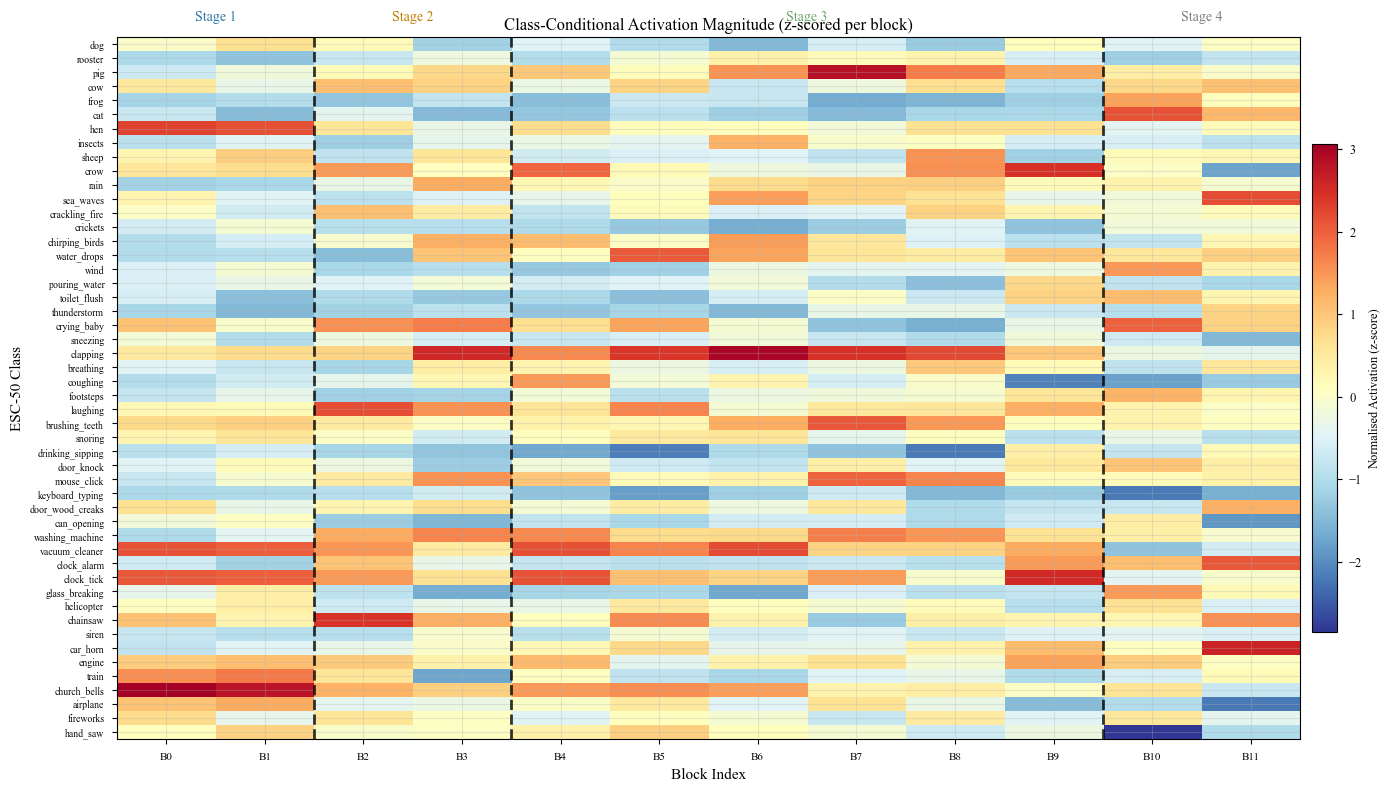


STEP 3B — Fisher discriminability curve
   ✓ Saved: fisher_discriminability.pdf/png


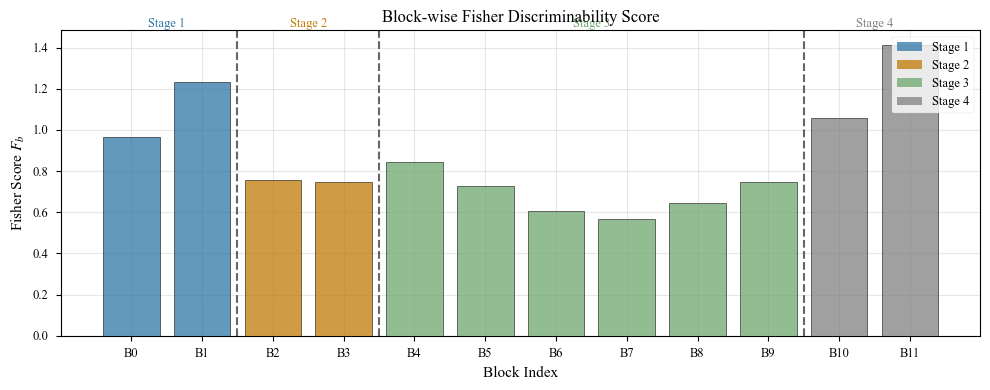


STEP 4 — Mean Ablation (full dataset)
   Loading CLAP model...
Loading audio files


2000it [00:00, 17659.74it/s]

   Dataset: 2000 samples, 50 classes

   Building stratified subset: 5 samples/class → 250 total
   ✅ Subset: 250 samples, 50 classes covered

   Computing baseline (no ablation)...


   Baseline: 96.00%


   Ablating blocks:   8%|▊         | 1/12 [00:56<10:20, 56.37s/block, block=1 (L0)]

   Block  0 (L0): acc=87.60%  Δ=+8.40%


   Ablating blocks:  17%|█▋        | 2/12 [01:51<09:15, 55.57s/block, block=2 (L1)]

   Block  1 (L0): acc=96.00%  Δ=+0.00%


   Ablating blocks:  25%|██▌       | 3/12 [02:46<08:17, 55.31s/block, block=3 (L1)]

   Block  2 (L1): acc=95.60%  Δ=+0.40%


   Ablating blocks:  33%|███▎      | 4/12 [03:40<07:19, 54.89s/block, block=4 (L2)]

   Block  3 (L1): acc=96.40%  Δ=-0.40%


   Ablating blocks:  42%|████▏     | 5/12 [04:36<06:25, 55.07s/block, block=5 (L2)]

   Block  4 (L2): acc=95.60%  Δ=+0.40%


   Ablating blocks:  50%|█████     | 6/12 [05:30<05:29, 54.85s/block, block=6 (L2)]

   Block  5 (L2): acc=96.00%  Δ=+0.00%


   Ablating blocks:  58%|█████▊    | 7/12 [06:25<04:34, 54.82s/block, block=7 (L2)]

   Block  6 (L2): acc=95.20%  Δ=+0.80%


   Ablating blocks:  67%|██████▋   | 8/12 [07:19<03:39, 54.76s/block, block=8 (L2)]

   Block  7 (L2): acc=95.20%  Δ=+0.80%


   Ablating blocks:  75%|███████▌  | 9/12 [08:14<02:44, 54.76s/block, block=9 (L2)]

   Block  8 (L2): acc=96.00%  Δ=+0.00%


   Ablating blocks:  83%|████████▎ | 10/12 [09:09<01:49, 54.90s/block, block=10 (L3)]

   Block  9 (L2): acc=96.40%  Δ=-0.40%


   Ablating blocks:  92%|█████████▏| 11/12 [10:04<00:54, 54.69s/block, block=11 (L3)]

   Block 10 (L3): acc=96.00%  Δ=+0.00%


   Ablating blocks: 100%|██████████| 12/12 [10:59<00:00, 54.98s/block, block=11 (L3)]


   Block 11 (L3): acc=96.80%  Δ=-0.80%

   ✅ Mean ablation complete

STEP 5 — Fisher vs Ablation correlation
   Pearson  r = 0.009,  p = 0.9767
   Spearman ρ = -0.333,  p = 0.2905
   ✓ Saved: fisher_vs_ablation.pdf/png


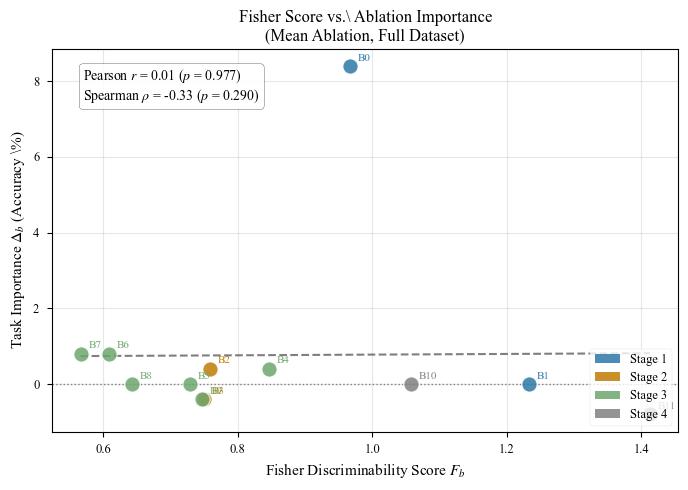


SUMMARY

   Baseline accuracy : 96.00%

    Block  Layer   Fisher F  Δ Acc (%)
        0  L   0      0.9670       +8.40
        1  L   0      1.2328       +0.00
        2  L   1      0.7583       +0.40
        3  L   1      0.7493       -0.40
        4  L   2      0.8464       +0.40
        5  L   2      0.7286       +0.00
        6  L   2      0.6082       +0.80
        7  L   2      0.5664       +0.80
        8  L   2      0.6428       +0.00
        9  L   2      0.7464       -0.40
       10  L   3      1.0572       +0.00
       11  L   3      1.4130       -0.80

   Fisher–Ablation Correlation:
   Pearson  r = 0.009,  p = 0.9767
   Spearman ρ = -0.333,  p = 0.2905

   Top-3 Fisher blocks  : [11, 1, 10]
   Top-3 Ablation blocks: [0, 6, 7]
   Overlap              : none

✅ Outputs saved:
   - class_activation_heatmap.pdf/png
   - fisher_discriminability.pdf/png
   - fisher_vs_ablation.pdf/png


In [1]:
# ============================================================================
# CLASS-CONDITIONAL ACTIVATION ANALYSIS + MEAN ABLATION
# Steps:
#   1. Load data & aggregate per block (mean over heads)
#   2. Compute Fisher Discriminability Score per block
#   3. Visualize: heatmap (classes x blocks) + Fisher curve
#   4. Mean ablation on full dataset → compute ablation_deltas
#   5. Correlate Fisher vs Ablation delta
# ============================================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from collections import defaultdict
from tqdm import tqdm

# ============================================================================
# CONFIGURATION
# ============================================================================
DATASET_NAME  = 'esc50'
HTSAT_DEPTHS  = [2, 2, 6, 2]
HTSAT_HEADS   = [4, 8, 16, 32]

ESC50_CLASSES = [
    'dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects',
    'sheep', 'crow', 'rain', 'sea_waves', 'crackling_fire', 'crickets',
    'chirping_birds', 'water_drops', 'wind', 'pouring_water', 'toilet_flush',
    'thunderstorm', 'crying_baby', 'sneezing', 'clapping', 'breathing',
    'coughing', 'footsteps', 'laughing', 'brushing_teeth', 'snoring',
    'drinking_sipping', 'door_knock', 'mouse_click', 'keyboard_typing',
    'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner',
    'clock_alarm', 'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw',
    'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane',
    'fireworks', 'hand_saw'
]

COLORS = {0: '#2d77a6', 1: '#bf7b04', 2: '#6ea66d', 3: '#808080'}

# Samples per class for ablation study.
# Set to None to use the full dataset (requires GPU).
# 2  → 100 samples total on ESC-50  (CPU-safe, for testing)
# 40 → 2000 samples total on ESC-50 (full dataset, requires GPU)
N_ABLATION_SAMPLES_PER_CLASS = 5

plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'mathtext.fontset': 'stix',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 13,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.axisbelow': True,
})

# ============================================================================
# STEP 1: LOAD DATA & AGGREGATE PER BLOCK (mean over heads)
# ============================================================================
print("=" * 70)
print("STEP 1 — Loading data and aggregating per block")
print("=" * 70)

data_path = f'heads_representations/{DATASET_NAME}_head_outputs_final.pt'
loaded    = torch.load(data_path, weights_only=False)
head_outputs_final = loaded['head_outputs_final']
sample_labels      = loaded['labels']

N_samples = len(sample_labels)
N_classes = len(np.unique(sample_labels))
N_blocks  = sum(HTSAT_DEPTHS)  # 12

print(f"   Samples : {N_samples}")
print(f"   Classes : {N_classes}")
print(f"   Blocks  : {N_blocks}")

# Build global_block → list of head_ids and block → layer mapping
block_to_heads = defaultdict(list)
block_layer    = []
global_block   = 0
for layer_idx, depth in enumerate(HTSAT_DEPTHS):
    for block_idx in range(depth):
        for head_idx in range(HTSAT_HEADS[layer_idx]):
            hid = f"L{layer_idx}_B{block_idx}_H{head_idx}"
            block_to_heads[global_block].append(hid)
        block_layer.append(layer_idx)
        global_block += 1

# Aggregate: mean over heads → (N_samples, D)
block_representations = {}
for b in range(N_blocks):
    stacked = np.stack(
        [head_outputs_final[hid].numpy() for hid in block_to_heads[b]],
        axis=0
    )
    block_representations[b] = stacked.mean(axis=0)  # (N_samples, D)
    print(f"   Block {b:2d} (L{block_layer[b]}): shape {block_representations[b].shape}")

# Dataset-level mean per block for mean ablation.
# Must match the full layer output dim (layer_dim = embed_dim * 2^layer),
# NOT the per-head dim. Concatenate per-head means to get the full vector.
def get_layer_dim(layer_idx):
    return int(96 * (2 ** layer_idx))  # HTSAT embed_dim = 96

block_mean = {}
for b in range(N_blocks):
    layer_idx = block_layer[b]
    layer_dim = get_layer_dim(layer_idx)
    head_means = np.stack(
        [head_outputs_final[hid].numpy().mean(axis=0)
         for hid in block_to_heads[b]],
        axis=0
    )
    # Concatenate head means -> full layer_dim vector matching hook x shape
    block_mean[b] = head_means.reshape(-1)  # (layer_dim,)
    assert block_mean[b].shape[0] == layer_dim, (
        f"Block {b}: expected dim {layer_dim}, got {block_mean[b].shape[0]}")
    print(f"   block_mean[{b}] shape: {block_mean[b].shape}")

# Layer boundary positions for plots
layer_boundaries = []
cum = 0
for d in HTSAT_DEPTHS[:-1]:
    cum += d
    layer_boundaries.append(cum - 0.5)

print("\n   ✅ Block representations ready")

# ============================================================================
# STEP 2: FISHER DISCRIMINABILITY SCORE PER BLOCK
# ============================================================================
print("\n" + "=" * 70)
print("STEP 2 — Computing Fisher Discriminability Score")
print("=" * 70)

def fisher_score(X, y):
    """
    Multivariate Fisher criterion (diagonal approximation):
        F = mean( S_B / (S_W + eps) )
    S_B = between-class scatter (weighted by class size)
    S_W = within-class scatter
    Returns scalar F.
    """
    classes   = np.unique(y)
    mu_global = X.mean(axis=0)
    S_B = np.zeros(X.shape[1])
    S_W = np.zeros(X.shape[1])
    for c in classes:
        X_c  = X[y == c]
        mu_c = X_c.mean(axis=0)
        n_c  = len(X_c)
        S_B += n_c * (mu_c - mu_global) ** 2
        S_W += ((X_c - mu_c) ** 2).sum(axis=0)
    return float((S_B / (S_W + 1e-8)).mean())

fisher_scores = {}
for b in range(N_blocks):
    fisher_scores[b] = fisher_score(block_representations[b], sample_labels)
    print(f"   Block {b:2d} (L{block_layer[b]}): F = {fisher_scores[b]:.4f}")

print("\n   ✅ Fisher scores computed")

# ============================================================================
# STEP 3A: CLASS-ACTIVATION HEATMAP (classes × blocks)
# ============================================================================
print("\n" + "=" * 70)
print("STEP 3A — Class-activation heatmap")
print("=" * 70)

heatmap = np.zeros((N_classes, N_blocks))
for b in range(N_blocks):
    X = block_representations[b]
    for c in range(N_classes):
        X_c = X[sample_labels == c]
        heatmap[c, b] = np.linalg.norm(X_c.mean(axis=0))

# Z-score per block to make stages comparable
heatmap_norm = (heatmap - heatmap.mean(axis=0, keepdims=True)) / \
               (heatmap.std(axis=0, keepdims=True) + 1e-8)

fig, ax = plt.subplots(figsize=(14, 8))
im = ax.imshow(heatmap_norm, aspect='auto', cmap='RdYlBu_r', interpolation='nearest')

for boundary in layer_boundaries:
    ax.axvline(x=boundary, color='black', linewidth=2, linestyle='--', alpha=0.8)

cum = 0
for layer_idx, depth in enumerate(HTSAT_DEPTHS):
    mid = cum + depth / 2 - 0.5
    ax.text(mid, -1.5, f'Stage {layer_idx+1}',
            ha='center', va='bottom', fontsize=10,
            fontweight='bold', color=COLORS[layer_idx])
    cum += depth

ax.set_xticks(range(N_blocks))
ax.set_xticklabels([f'B{b}' for b in range(N_blocks)], fontsize=8)
ax.set_yticks(range(N_classes))
ax.set_yticklabels(ESC50_CLASSES[:N_classes], fontsize=7)
ax.set_xlabel('Block Index', fontsize=11)
ax.set_ylabel('ESC-50 Class', fontsize=11)
ax.set_title('Class-Conditional Activation Magnitude (z-scored per block)',
             fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax, fraction=0.02, pad=0.01).set_label(
    'Normalised Activation (z-score)', fontsize=9)

plt.tight_layout()
plt.savefig('class_activation_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.savefig('class_activation_heatmap.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: class_activation_heatmap.pdf/png")
plt.show()

# ============================================================================
# STEP 3B: FISHER SCORE CURVE PER BLOCK
# ============================================================================
print("\n" + "=" * 70)
print("STEP 3B — Fisher discriminability curve")
print("=" * 70)

f_vals = [fisher_scores[b] for b in range(N_blocks)]

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(range(N_blocks), f_vals,
       color=[COLORS[block_layer[b]] for b in range(N_blocks)],
       alpha=0.75, edgecolor='black', linewidth=0.5, zorder=3)

for boundary in layer_boundaries:
    ax.axvline(x=boundary, color='black', linestyle='--', linewidth=1.5, alpha=0.6)

cum = 0
for layer_idx, depth in enumerate(HTSAT_DEPTHS):
    mid = cum + depth / 2 - 0.5
    ax.text(mid, max(f_vals) * 1.05, f'Stage {layer_idx+1}',
            ha='center', va='bottom', fontsize=9,
            fontweight='bold', color=COLORS[layer_idx])
    cum += depth

ax.set_xticks(range(N_blocks))
ax.set_xticklabels([f'B{b}' for b in range(N_blocks)])
ax.set_xlabel('Block Index', fontsize=11)
ax.set_ylabel('Fisher Score $F_b$', fontsize=11)
ax.set_title('Block-wise Fisher Discriminability Score', fontsize=12, fontweight='bold')
ax.legend(handles=[Patch(facecolor=COLORS[i], alpha=0.75, label=f'Stage {i+1}')
                   for i in range(4)], loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('fisher_discriminability.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fisher_discriminability.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: fisher_discriminability.pdf/png")
plt.show()

# ============================================================================
# STEP 4: MEAN ABLATION ON FULL DATASET
# ============================================================================
print("\n" + "=" * 70)
print("STEP 4 — Mean Ablation (full dataset)")
print("=" * 70)

print("   Loading CLAP model...")
from CLAPWrapper import CLAPWrapper
from datasets.esc50 import ESC50

device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
wrapper = CLAPWrapper(version='2023', use_cuda=torch.cuda.is_available())
audio_encoder = wrapper.clap.audio_encoder.base.htsat
audio_encoder.eval()

dataset = ESC50(root='../data', download=False)
print(f"   Dataset: {len(dataset)} samples, {len(dataset.classes)} classes")

# Build stratified subset for ablation
if N_ABLATION_SAMPLES_PER_CLASS is not None:
    n_total = N_ABLATION_SAMPLES_PER_CLASS * len(dataset.classes)
    print(f"\n   Building stratified subset: "
          f"{N_ABLATION_SAMPLES_PER_CLASS} samples/class → {n_total} total")
    class_buckets = defaultdict(list)
    for idx in range(len(dataset)):
        audio_path, class_name, _ = dataset[idx]
        if len(class_buckets[class_name]) < N_ABLATION_SAMPLES_PER_CLASS:
            class_buckets[class_name].append((audio_path, class_name))
        if all(len(v) >= N_ABLATION_SAMPLES_PER_CLASS
               for v in class_buckets.values()):
            break
    ablation_samples = [s for bucket in class_buckets.values() for s in bucket]
    print(f"   ✅ Subset: {len(ablation_samples)} samples, "
          f"{len(class_buckets)} classes covered")
else:
    ablation_samples = []
    for idx in range(len(dataset)):
        audio_path, class_name, _ = dataset[idx]
        ablation_samples.append((audio_path, class_name))
    print(f"   Using full dataset: {len(ablation_samples)} samples")

def evaluate_zero_shot(wrapper_obj, samples, class_names,
                        ablated_block=None, mean_val=None, desc="Evaluating"):
    """
    Zero-shot classification on a list of (audio_path, class_name) tuples.
    If ablated_block is set, replaces that block's attention output
    with the dataset-mean vector (mean ablation).
    """
    text_prompts    = [f"the sound of {cls}" for cls in class_names]
    text_embeddings = wrapper_obj.get_text_embeddings(text_prompts)

    hook_handle = None

    if ablated_block is not None:
        # Map global block → (layer_idx, block_in_layer)
        cum = 0
        for layer_idx, depth in enumerate(HTSAT_DEPTHS):
            if ablated_block < cum + depth:
                block_in_layer = ablated_block - cum
                break
            cum += depth

        mean_tensor = torch.tensor(mean_val, dtype=torch.float32).to(device)

        def mean_ablation_hook(module, input, output):
            x, attn = output
            x_ablated = mean_tensor.unsqueeze(0).unsqueeze(0).expand_as(x)
            return (x_ablated, attn)

        target      = audio_encoder.layers[layer_idx].blocks[block_in_layer].attn
        hook_handle = target.register_forward_hook(mean_ablation_hook)

    correct = 0
    sample_pbar = tqdm(samples, desc=f"      {desc}",
                       leave=False, unit="sample")
    for audio_path, class_name in sample_pbar:
        audio_emb  = wrapper_obj.get_audio_embeddings([audio_path], resample=True)
        similarity = wrapper_obj.compute_similarity(audio_emb, text_embeddings)
        pred_idx   = similarity.argmax(dim=1).item()
        true_idx   = class_names.index(class_name)
        if pred_idx == true_idx:
            correct += 1
        sample_pbar.set_postfix({'acc': f'{correct/max(1,sample_pbar.n)*100:.1f}%'})

    if hook_handle is not None:
        hook_handle.remove()

    return correct / len(samples)

# Baseline
print("\n   Computing baseline (no ablation)...")
baseline_acc = evaluate_zero_shot(wrapper, ablation_samples,
                                   dataset.classes, desc="Baseline")
print(f"   Baseline: {baseline_acc*100:.2f}%")

# Ablate each block
ablation_deltas = {}
block_pbar = tqdm(range(N_blocks), desc="   Ablating blocks", unit="block")
for b in block_pbar:
    block_pbar.set_postfix({'block': f'{b} (L{block_layer[b]})'})
    acc_b = evaluate_zero_shot(wrapper, ablation_samples, dataset.classes,
                                ablated_block=b, mean_val=block_mean[b],
                                desc=f"B{b}/L{block_layer[b]}")
    delta              = (baseline_acc - acc_b) * 100
    ablation_deltas[b] = delta
    block_pbar.write(f"   Block {b:2d} (L{block_layer[b]}): "
                     f"acc={acc_b*100:.2f}%  Δ={delta:+.2f}%")

print("\n   ✅ Mean ablation complete")

# ============================================================================
# STEP 5: CORRELATE FISHER vs ABLATION DELTA
# ============================================================================
print("\n" + "=" * 70)
print("STEP 5 — Fisher vs Ablation correlation")
print("=" * 70)

f_arr     = np.array([fisher_scores[b]   for b in range(N_blocks)])
delta_arr = np.array([ablation_deltas[b] for b in range(N_blocks)])

pearson_r,  pearson_p  = pearsonr(f_arr,  delta_arr)
spearman_r, spearman_p = spearmanr(f_arr, delta_arr)

print(f"   Pearson  r = {pearson_r:.3f},  p = {pearson_p:.4f}")
print(f"   Spearman ρ = {spearman_r:.3f},  p = {spearman_p:.4f}")

fig, ax = plt.subplots(figsize=(7, 5))

for b in range(N_blocks):
    ax.scatter(fisher_scores[b], ablation_deltas[b],
               color=COLORS[block_layer[b]], s=120, alpha=0.85,
               edgecolors='white', linewidth=0.8, zorder=3)
    ax.annotate(f'B{b}',
                (fisher_scores[b], ablation_deltas[b]),
                textcoords='offset points', xytext=(6, 4),
                fontsize=8, color=COLORS[block_layer[b]])

m, q   = np.polyfit(f_arr, delta_arr, 1)
x_line = np.linspace(f_arr.min(), f_arr.max(), 100)
ax.plot(x_line, m * x_line + q, 'k--', linewidth=1.5, alpha=0.5)
ax.axhline(y=0, color='gray', linewidth=1, linestyle=':')

ax.text(0.05, 0.95,
        f'Pearson $r$ = {pearson_r:.2f} ($p$ = {pearson_p:.3f})\n'
        f'Spearman $\\rho$ = {spearman_r:.2f} ($p$ = {spearman_p:.3f})',
        transform=ax.transAxes, fontsize=10, va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))

ax.set_xlabel('Fisher Discriminability Score $F_b$', fontsize=11)
ax.set_ylabel('Task Importance $\\Delta_b$ (Accuracy \%)', fontsize=11)
ax.set_title('Fisher Score vs.\ Ablation Importance\n(Mean Ablation, Full Dataset)',
             fontsize=12, fontweight='bold')
ax.legend(handles=[Patch(facecolor=COLORS[i], alpha=0.85, label=f'Stage {i+1}')
                   for i in range(4)], loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fisher_vs_ablation.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fisher_vs_ablation.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: fisher_vs_ablation.pdf/png")
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"\n   Baseline accuracy : {baseline_acc*100:.2f}%")
print(f"\n   {'Block':>6} {'Layer':>6} {'Fisher F':>10} {'Δ Acc (%)':>10}")
for b in range(N_blocks):
    print(f"   {b:>6}  L{block_layer[b]:>4}  "
          f"{fisher_scores[b]:>10.4f}  {ablation_deltas[b]:>+10.2f}")

print(f"\n   Fisher–Ablation Correlation:")
print(f"   Pearson  r = {pearson_r:.3f},  p = {pearson_p:.4f}")
print(f"   Spearman ρ = {spearman_r:.3f},  p = {spearman_p:.4f}")

top_f = sorted(range(N_blocks), key=lambda b: fisher_scores[b],   reverse=True)[:3]
top_a = sorted(range(N_blocks), key=lambda b: ablation_deltas[b], reverse=True)[:3]
print(f"\n   Top-3 Fisher blocks  : {top_f}")
print(f"   Top-3 Ablation blocks: {top_a}")
print(f"   Overlap              : {set(top_f) & set(top_a) or 'none'}")

print("\n✅ Outputs saved:")
print("   - class_activation_heatmap.pdf/png")
print("   - fisher_discriminability.pdf/png")
print("   - fisher_vs_ablation.pdf/png")